# Home Assignment No. 2 - part two

To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* You have to write **CODE** directly inside specified places marked by comments: **BEGIN/END Solution**. Do not create new cells.

* In some problems you are asked to provide a short discussion of the results. For that find the specific place marked via **Your text answer: \<write your answer\>**.

* For every separate problem or subproblem (if specified) you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task.

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e., if the reviewer decides to restart the notebook and run all cells, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest fixing random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include necessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.


## Task 6. Deep ANNs. (3 points)

-  **(1 pt.)** Activation functions; **(sub tasks 6.1)**
-  **(2 pt.)** MNIST classification.  **(sub tasks 6.2)**



### Task 6.1  Activation functions. 
Plot the following [activation functions](https://pytorch.org/docs/master/nn.html#non-linear-activation-functions) using their PyTorch implementation and their derivatives using [autograd](https://pytorch.org/docs/stable/autograd.html) functionality `grad()`:
   
1. Plot `ReLU`, `ELU` ($\alpha = 1$), `Softplus` ($\beta = 1$) and `Sign`, `Sigmoid`, `Softsign`, `Tanh`.


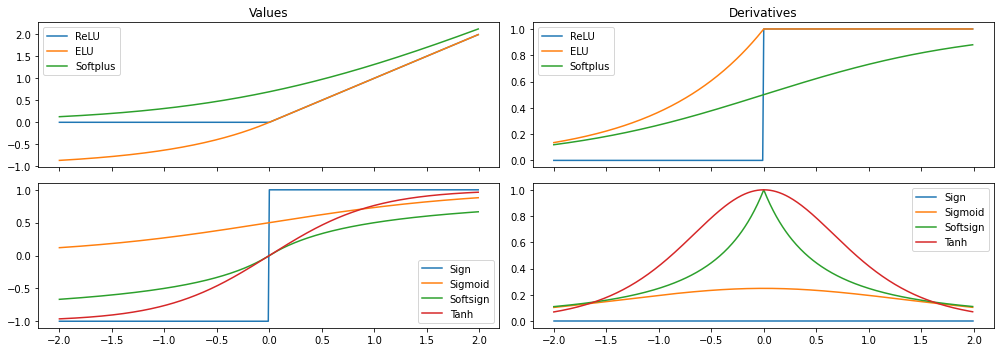

In [1]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

x = torch.arange(-2, 2, .01, requires_grad=True)
x_np = x.detach().numpy()
x.sum().backward() # to create x.grad 

f, axes = plt.subplots(2, 2, sharex=True, figsize=(14, 5))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), ('Tanh', torch.tanh))):
    for function_name, activation in function_set:
        ### BEGIN Solution
        
        ## 1. Calculate activation function at each point of vector x
        activation_tensor = activation(x)
        activation_np = activation_tensor.detach().numpy()
        axes[i, 0].plot(x_np, activation_np, label=function_name)
        
        ## 2. Calculate the derivative at each point of vector x
        # to zero x.grad created previously
        x.grad.zero_() 
        # since activation_tensor is a tensor (not a scalar function),
        # we should pass a tensor of ones to obtain the derivatives
        ones = torch.ones(x.shape) 
        activation_tensor.backward(ones) 
        activation_derivative_np = x.grad.detach().numpy()
        axes[i, 1].plot(x_np, activation_derivative_np, label=function_name)
         
        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

Which of these functions may be, and which - definitely, are a poor choise as an activation function in a neural network? Why? Do not forget that output of the current layer servers as an input for the following one. Imagine a situation where we have many layers, what happens with the activation values?







In [2]:
# BEGIN SOLUTION (do not delete this comment!)

# *   ReLU - may be an activation function, because 
#               +) makes SGD converge faster compared to sigmoid/tanh
#               +) easy to calculate the function and its gradient (can define grad at 0 specifically)
#               -) sometimes neurons with ReLU can 'die' (if weights on a neuron were updated so that
#                                      for all values in dataset the value of neuron's function < 0,
#                                      then RelU(function) = ReLU(x<0) = 0, i.e. output of this neuron = 0
#                                      for all values. It also means that we can't change weights during 
#                                      backprop, because grad(ReLU(x<0)) =  0. Therefore, this neuron 
#                                      will 'die', since no signal will go through it.)
# *   ELU - may be an activation function, because
#               +) resolves problem of 'dying' neurons related with ReLU
#               -) computationally expensive (exp) in comparision with ReLU 
# *   Softplus - may be an activation function, because 
#               +) in contrast to ReLU, it's differentiable at any point
#               -) computationally expensive (exp, log) in comparision with ReLU
# *   Sign - definitely a poor choice, because
#               -) everywhere grad = 0, so learning with it is impossible
# *   Sigmoid - not very good choice, but it is still sometimes used
#               -) it kills gradients (during backprop, local gradient will be multiplied to 
#                                      gradients on previous layers, if local gradient close to 0, then
#                                      the product also will be close to 0. This is a big obstacle 
#                                      during training)
#               -) computationally expensive (exponential function)
#               -) outputs are not zero-centered
#               +) it squashes real numbers into range [0,1]
# *   Tanh - may be an activation function, because 
#               +) in contrast to sigmoid its outputs are zero-centered
#               -) computationally expensive (exp) in comparision with ReLU
#               -) it still kills gradients, since tanh(x)=2*sigmoid(2x)−1

#END SOLUTION (do not delete this comment!)

### Task 6.2 MNIST classification. 

At one of the seminars we have discussed an MLP (Multilayer perceptron) with one hidden layer, logistic activation functions and softmax. In this task, you are to:

1. Implement the MLP modules, including the Softmax cross entropy between `logits` and `labels` using numpy.

2.  Train your numpy realization of MLP to classify the MNIST from `sklearn.datasets()`. The required accuracy on validation is `> 90%`.

3.  Compare the acccuracy of classification to your scores from `Part 1` with and without dimensionality reduction. Is this comparison fair?:) Derive the confusion matrix for all digits classes. Which digits are predicted better or worse than others, why?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]
test_size = digits_test.shape[0]

input_size = 8*8
classes_n = 10

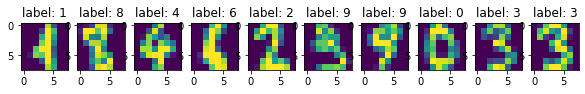

In [5]:
N = 10

sample_idx = np.random.choice(1797, N, replace=False)
digits_sample = digits[sample_idx]
targets_sample = targets[sample_idx]
f, ax  = plt.subplots(1,10, figsize=(10, 5))

for i in range(N):
    ax[i].imshow(digits_sample[i].reshape(8,8))
    ax[i].set_title('label: '+str(targets_sample[i]))


A short recap on what we are going to achieve here.
<br>
1. Forward pass:
$$
h_1 = X\theta_1+\beta_1
$$

$$
O_1 = sig(h_1)
$$

$$
h_2 = O_1\theta_2+\beta_2
$$
$$
O_2 = softmax(h_2)
$$
$$
Loss = CrossEntropy(O_2, true \space labels)
$$

2. Compute gradients: 

To update weights first we need to compute loss gradients with respect to $\theta_1$ and $\theta_2$ and then update both $\theta$ and $\beta$.

$$
\frac{ \partial{loss} }{\partial{\theta_2}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{\theta_2}}
$$
Note, that $\frac{ \partial{h_2} }{\partial{\theta_2}}=O_1$, so we can cache this value during forward pass to speed up our computation.
$$
\frac{ \partial{loss} }{\partial{\theta_1}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{O_1}}\frac{ \partial{O_1} }{\partial{h_1}}\frac{ \partial{h_1} }{\partial{\theta_1}}
$$
Note, that $\frac{ \partial{h_1} }{\partial{\theta_1}}=X$.

Since we are using sigmoid avtivation function here and
$$
\frac{ \partial{sig} }{\partial{h}} = sig(h)(1 - sig(h))
$$
It also makes sense to cache sig(h) during forward pass.

3. Update weights:

$\theta:= \theta -  \frac{ \partial{loss} }{\partial{\theta}}\alpha$, where $\alpha$ is some learning rate.

Note, it was not shown here how to update and compute $\beta$ but you can do it!

### Implement the MLP with backprop

In [6]:
### YOUR TASK STARTS HERE ###

#Here you should implement by yourself MLP class and its constituents including forward and backward propagation methods

class Linear:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.thetas = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.thetas_grads = np.empty_like(self.thetas) # gradient w.r.t. the weight matrix of the layer
        self.bias = np.random.randn(output_size) # bias terms of the layer (b)
        self.bias_grads = np.empty_like(self.bias) # gradient w.r.t. bias terms of the linear layer

    def forward(self, x): 
        # keep x for backward computation
        self.x = x
        output = np.matmul(x, self.thetas) + self.bias
        return output
    
    def backward(self, output_grad, learning_rate):
        """
        Calculate and return gradient of the loss w.r.t. the input of linear layer given the input x and the gradient 
        w.r.t output of linear layer. You should also calculate and update gradients of layer parameters.
        :param x: np.array, input tensor for linear layer;
        :param output_grad: np.array, grad tensor w.r.t output of linear layer;
        :return: np.array, grad w.r.t input of linear layer
        """
        
        # BEGIN SOLUTION (do not delete this comment!)
        
        # >>> your solution here <<<
        self.thetas_grads = np.matmul(self.x.T, output_grad)
        self.bias_grads = output_grad.sum(axis=0)
        input_grad = np.matmul(output_grad, self.thetas.T)

        # END Solution (do not delete this comment!)
        
        return input_grad

    def step(self, learning_rate):
        self.thetas -= self.thetas_grads * learning_rate
        self.bias -= self.bias_grads * learning_rate

class LogisticActivation:
    def __init__(self):
        # the layer has no parameters
        pass 
        
    def sig(self, x):
        return 1/(1 + np.exp(-x))

    def forward(self, x):
        # keep o for backward computation
        self.o = self.sig(x)
        return self.o 


    def backward(self, output_grad, learning_rate=None):
        """
        Calculate and return the gradient of the loss w.r.t. the input
        of logistic non-linearity (given input x and the gradient 
        w.r.t output of logistic non-linearity).
        
        :param x: np.array, input tensor for logistic non-linearity;
        :param output_grad: np.array, grad tensor w.r.t output of logistic non-linearity;
        :return: np.array, grad w.r.t input of logistic non-linearity
        
        """
        
        # BEGIN SOLUTION (do not delete this comment!)
        # >>> your solution here <<<
        
        grad_of_sigma_wrt_input = self.o * (np.ones_like(self.o) - self.o)
        input_grad = output_grad * grad_of_sigma_wrt_input

        ### END Solution (do not delete this comment!)
        
        return input_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        h1 = self.linear1.forward(x)
        h1a = self.activation1.forward(h1)
        out = self.linear2.forward(h1a)
        return out

    def backward(self, output_grad, learning_rate):
        """
        Calculate and return the gradient of the loss w.r.t. the input of MLP given the input and the gradient 
        w.r.t output of MLP. You should also update gradients of paramerters of MLP layers.
        Hint - you should chain backward operations of modules you have already implemented. You may also
        need to calculate intermediate forward results.
        
        :param x: np.array, input tensor for MLP;
        :param output_grad: np.array, grad tensor w.r.t output of MLP;
        :return: np.array, grad w.r.t input of MLP
        """
 
        # BEGIN SOLUTION (do not delete this comment!)
        # 1. Calculate the gradient of the loss w.r.t. the input of MLP
        grad_of_linear2_wrt_o1 = self.linear2.backward(output_grad, learning_rate)
        grad_of_activ1_wrt_h1 = self.activation1.backward(grad_of_linear2_wrt_o1, learning_rate)
        out = self.linear1.backward(grad_of_activ1_wrt_h1, learning_rate)
        
        # 2. Update gradients of paramerters of MLP layers
        self.linear2.step(learning_rate)
        self.linear1.step(learning_rate)
        # END Solution (do not delete this comment!)
        

        return  out

In [7]:
# BEGIN SOLUTION (do not delete this comment!)

def softmax_crossentropy_with_logits(logits, reference_answers): 
    # I derived formulas for the case when reference_answers is 
    # a matrix with shape (batch_size, num_classes), containing 0 and 1.
    # So let's make it like that with one-hot encoding: 
    reference_answers_one_hot = np.zeros((1, logits.shape[-1]))
    reference_answers_one_hot[0, reference_answers[0]] = 1
    
    # Calculate loss = Σ losses[i]
    ## log_softmax is a matrix, where log_softmax[ik] = log(softmax(logits[ik])).
    exponent = np.exp(logits)
    log_softmax = logits - np.log(np.sum(exponent, axis=1, keepdims=True))
    ## losses is an array, where losses[i] = - Σ(by k) true_labels[ik] * log(pred_labels)[ik] 
    losses = - np.sum(reference_answers_one_hot * log_softmax, axis=1)
    loss = np.sum(losses, axis=0)
    return loss


def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    # I derived formulas for the case when reference_answers is 
    # a matrix with shape (batch_size, num_classes), containing 0 and 1.
    # So let's make it like that with one_hot_encoding: 
    reference_answers_one_hot = np.zeros((1, logits.shape[-1]))
    reference_answers_one_hot[0, reference_answers[0]] = 1
    
    # Calculate grad = d(loss)/d(logits) = d(loss)/d(softmax) * d(softmax)/d(logits):
    exponent = np.exp(logits)
    softmax = exponent/np.sum(exponent, axis=1, keepdims=True)    
    grad = -reference_answers_one_hot + softmax
    return grad

# END SOLUTION (do not delete this comment!)

In [8]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
    
    y_pred = []

    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])

        ### BEGIN Solution
        # ... perform forward pass and compute the loss
        logits = mlp.forward(x)
        loss = softmax_crossentropy_with_logits(logits, target)
        # ... compute the gradients w.r.t. the input of softmax layer
        grad_wrt_input_of_softmax = grad_softmax_crossentropy_with_logits(logits, target)
        # ... perform backward pass
        # ... and update the weights with weight -= grad * learning_rate
        mlp.backward(grad_wrt_input_of_softmax, learning_rate)
        ### END Solution

        y_pred.extend(logits.argmax(1))

    if epoch % 10 == 0:
        
        y_pred_test = []

        for sample_i in range(test_size):
            x = x_test[sample_i].reshape((1, -1))
            target = np.array([y_test[sample_i]])
            
            logits = mlp.forward(x)
            y_pred_test.extend(logits.argmax(1))

        print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(loss), \
              ', Accuracy on train: {:.3}'.format(accuracy_score(y_train, y_pred)), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_test, y_pred_test)) )

Starting epoch 0 , Loss : 2.71 , Accuracy on train: 0.103 , Accuracy on test: 0.0667
Starting epoch 10 , Loss : 2.15 , Accuracy on train: 0.625 , Accuracy on test: 0.649
Starting epoch 20 , Loss : 1.55 , Accuracy on train: 0.821 , Accuracy on test: 0.807
Starting epoch 30 , Loss : 1.07 , Accuracy on train: 0.875 , Accuracy on test: 0.871
Starting epoch 40 , Loss : 0.742 , Accuracy on train: 0.9 , Accuracy on test: 0.889
Starting epoch 50 , Loss : 0.534 , Accuracy on train: 0.911 , Accuracy on test: 0.904
Starting epoch 60 , Loss : 0.399 , Accuracy on train: 0.92 , Accuracy on test: 0.924
Starting epoch 70 , Loss : 0.308 , Accuracy on train: 0.927 , Accuracy on test: 0.931
Starting epoch 80 , Loss : 0.245 , Accuracy on train: 0.929 , Accuracy on test: 0.931
Starting epoch 90 , Loss : 0.198 , Accuracy on train: 0.936 , Accuracy on test: 0.933


In [9]:
# BEGIN SOLUTION (do not delete this comment!)
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, np.array(y_pred_test), labels=[0,1,2,3,4,5,6,7,8,9]))
print('\n')

# # *   0, 4, 5, 6, 7 are predicted better than others (they have from 0 to 2 errors).
# #     This happens because almost all examples with these digits in our test set have clear shape.
# # *   8 and 9 are predicted much worse than others (7 and 8 errors).
# #     There are some irregular-shaped 8s and 9s, so that some 8s are very similar to 1, 
# #     and some 9s are similar to 3. Perhaps, in train set there were not so much 
# #     indistinct train examples for these digits.


# Let's run classification on reduced dimension
n_components = 50
epochs_n = 100
learning_rate = 1e-2

reducer = PCA(n_components = n_components)

x_train_red = reducer.fit_transform(digits_train.reshape((digits_train.shape[0], -1)))
x_test_red = reducer.transform(digits_test.reshape((digits_test.shape[0], -1)))
y_train = targets_train
y_test = targets_test

mlp2 = MLP(input_size=n_components, hidden_layer_size=100, output_size=classes_n)

for epoch in range(epochs_n):
    
    y_pred = []

    for sample_i in range(train_size):
        x = x_train_red[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])

        ### BEGIN Solution
        # ... perform forward pass and compute the loss
        logits = mlp2.forward(x)
        loss = softmax_crossentropy_with_logits(logits, target)
        # ... compute the gradients w.r.t. the input of softmax layer
        grad_wrt_input_of_softmax = grad_softmax_crossentropy_with_logits(logits, target)
        # ... perform backward pass
        # ... and update the weights with weight -= grad * learning_rate
        mlp2.backward(grad_wrt_input_of_softmax, learning_rate)
        ### END Solution

        y_pred.extend(logits.argmax(1))

    if epoch % 10 == 0:
        
        y_pred_test_red = []

        for sample_i in range(test_size):
            x = x_test_red[sample_i].reshape((1, -1))
            target = np.array([y_test[sample_i]])
            
            logits = mlp2.forward(x)
            y_pred_test_red.extend(logits.argmax(1))

        print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(loss), \
              ', Accuracy on train: {:.3}'.format(accuracy_score(y_train, y_pred)), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_test, y_pred_test_red)) )
        
# confusion matrix
print('\n')
print('Confusion matrix for dimensionality reduction')
print(confusion_matrix(y_test, np.array(y_pred_test_red), labels=[0,1,2,3,4,5,6,7,8,9]))
# As we can see, with dimentionality reduction we got a slightly better accuracy

# END Solution (do not delete this comment!)

Confusion matrix
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  0  2]
 [ 0  2 40  1  0  0  0  1  0  0]
 [ 0  0  0 42  0  0  0  1  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  0]
 [ 0  4  1  0  0  1  0  1 41  0]
 [ 0  0  0  4  0  2  0  1  1 39]]


Starting epoch 0 , Loss : 2.79 , Accuracy on train: 0.137 , Accuracy on test: 0.14
Starting epoch 10 , Loss : 2.23 , Accuracy on train: 0.652 , Accuracy on test: 0.656
Starting epoch 20 , Loss : 1.64 , Accuracy on train: 0.853 , Accuracy on test: 0.836
Starting epoch 30 , Loss : 1.13 , Accuracy on train: 0.895 , Accuracy on test: 0.88
Starting epoch 40 , Loss : 0.765 , Accuracy on train: 0.915 , Accuracy on test: 0.904
Starting epoch 50 , Loss : 0.53 , Accuracy on train: 0.927 , Accuracy on test: 0.911
Starting epoch 60 , Loss : 0.379 , Accuracy on train: 0.933 , Accuracy on test: 0.924
Starting epoch 70 , Loss : 0.281 , Accuracy on train: 0.

## Task 7. Autoencoders on tabular data (2 points)
**From now on we will be using pytorch for all the tasks.**

We will build a latent representation for tabular data with simple Autoencoder (AE). We are going to work with the cancer dataset from scikit-learn package. You are to follow the instructions.  

1. **(1 pt.)**  Implement AE modules for tabular data. Train AE to get latent representation of the cancer dataset from `sklearn.datasets()`. Use `MSE` loss and get < $0.3$ on validation, with AE "bottleneck" = $2$;   **(sub tasks 7.1 - 7.5)**

2. **(1 pt.)** Plot the latent representation of whole dataset in 2D, use colors to show object of different classes. **(sub tasks: 7.6)**


In [10]:
# imports

import torch
import torch.nn as nn
import torch.utils.data as torch_data

import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [11]:
# BEGIN SOLUTION (do not delete this comment!)
# to fix random_seed
torch.manual_seed(20)
torch.backends.cudnn.deterministic = True
# END SOLUTION (do not delete this comment!)

#### 7.1 Fetch the data. Scale it and split on train and test.

In [12]:
cancer_dset = sk_data.load_breast_cancer()

X_train, X_val, y_train, y_val = train_test_split(cancer_dset['data'], cancer_dset['target'], test_size=0.2, random_state=42)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

scaler = StandardScaler() 
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

print('Features: ', list(cancer_dset['feature_names']))
print('\nShape:', X_train.shape)


Train size:  455
Validation size:  114
Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Shape: (455, 30)


#### 7.2 Let us firstly create the dataset, which we'll be able to use with pytorch dataloader. 
Implement `__len__` and `__getitem__` methods.

In [13]:
### BEGIN Solution

class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X) # >>> your solution here <<<
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] # >>> your solution here <<<


### END Solution

In [14]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 

print(train_dset[5])

(tensor([ 0.1196,  1.9607,  0.1995,  0.0125,  1.3055,  1.0662,  0.9448,  0.6670,
         1.7919,  1.1127, -0.1132, -0.3136,  0.0100, -0.1594, -0.4526,  0.9020,
         0.4543, -0.1581, -0.2454,  0.5911,  0.2549,  1.9137,  0.5098,  0.1168,
         1.5730,  2.6153,  2.0462,  0.8738,  2.0814,  2.8176]), tensor(0.))


#### 7.3 Now, we'll make a base class for our autoencoder. 
AE takes as input encoder and decoder (it will be two neural networks). Your task is to implement the forward pass.

In [15]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        # BEGIN SOLUTION (do not delete this comment!)
        x = self.decoder(self.encoder(x)) # >>> your solution here <<<
        # END Solution (do not delete this comment!)
        
        return x

#### It is high time to create encoder and decoder neural networks!
Make hidden size of the network to be equal to `2`.

**Hint.** You can use `nn.Sequential` to create your own archtectures.

In [16]:
encoder = lambda hid: nn.Sequential(
                        nn.Linear(X_train.shape[-1], 15),
                        nn.LeakyReLU(),
                        nn.Linear(15, 15),
                        nn.Dropout(p=0.2),
                        nn.LeakyReLU(),
                        nn.Linear(15, hid)
                        )  

decoder = lambda hid: nn.Sequential(
                        nn.Linear(hid, 15),
                        nn.LeakyReLU(),
                        nn.Linear(15, 15),
                        nn.LeakyReLU(),
                        nn.Linear(15, X_train.shape[-1])
                        ) 

In [17]:
device = 'cpu' # >>> your solution here <<<

net = MyFirstAE(encoder(2), decoder(2))  
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.03) # >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.4) # >>> your solution here <<<

train_loader = torch_data.DataLoader(train_dset, batch_size=50, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=200, shuffle=False) 

#### 7.4 Implement the missing parts of the `train` function

In [18]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    
    freq = max(epochs//20,1)
    net.to(device)
    
    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        for X, _ in train_loader:
            
            ### BEGIN Solution

            # Perform one step of minibatch stochastic gradient descent
            # >>> your solution here <<<
            X = X.to(device)
            optimizer.zero_grad()
            encoding_plus_decoding = net(X)
            loss = criterion(encoding_plus_decoding, X)
            loss.backward()
            optimizer.step()
            losses_train.append(loss)
            

        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, _ in val_loader:
            losses_val = [] 
            
            # Compute the validation loss
            # >>> your solution here <<<
            encoding_plus_decoding = net(X) 
            losses_val.append(criterion(encoding_plus_decoding, X))

            ### END Solution

        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            mean_val = sum(losses_val)/len(losses_val)
            mean_train = sum(losses_train)/len(losses_train)

            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'\
                  .format(epoch, epochs, mean_train, mean_val))

#### 7.5 Train your AE on breast cancer dataset. 
Your goal is to get validation error <0.3.

Some features that may help you to improve the performance:
* `Dropout`
* `Batchnorm`
* lr scheduler
* Batch size increase/decrease

In [19]:
# for `MSE` loss get < 0.3 on validation, with AE "bottleneck" = 2
train(150, net, criterion, optimizer, train_loader, val_loader, scheduler) 

Epoch 7/150 || Loss:  Train 0.4403 | Validation 0.3523
Epoch 14/150 || Loss:  Train 0.4359 | Validation 0.3958
Epoch 21/150 || Loss:  Train 0.3600 | Validation 0.3288
Epoch 28/150 || Loss:  Train 0.4275 | Validation 0.3401
Epoch 35/150 || Loss:  Train 0.4083 | Validation 0.3177
Epoch 42/150 || Loss:  Train 0.3369 | Validation 0.3382
Epoch 49/150 || Loss:  Train 0.3306 | Validation 0.3115
Epoch 56/150 || Loss:  Train 0.3748 | Validation 0.3099
Epoch 63/150 || Loss:  Train 0.2979 | Validation 0.2942
Epoch 70/150 || Loss:  Train 0.3143 | Validation 0.2956
Epoch 77/150 || Loss:  Train 0.3015 | Validation 0.2885
Epoch 84/150 || Loss:  Train 0.3093 | Validation 0.2890
Epoch 91/150 || Loss:  Train 0.3084 | Validation 0.2829
Epoch 98/150 || Loss:  Train 0.3039 | Validation 0.2862
Epoch 105/150 || Loss:  Train 0.2970 | Validation 0.2807
Epoch 112/150 || Loss:  Train 0.3167 | Validation 0.2806
Epoch 119/150 || Loss:  Train 0.3035 | Validation 0.2815
Epoch 126/150 || Loss:  Train 0.3494 | Validat

#### 7.5 Let us take a look at the latent space. 
Encode the whole dataset, using your AE, plot it in 2D and use colors to indicate objects of differrent classes

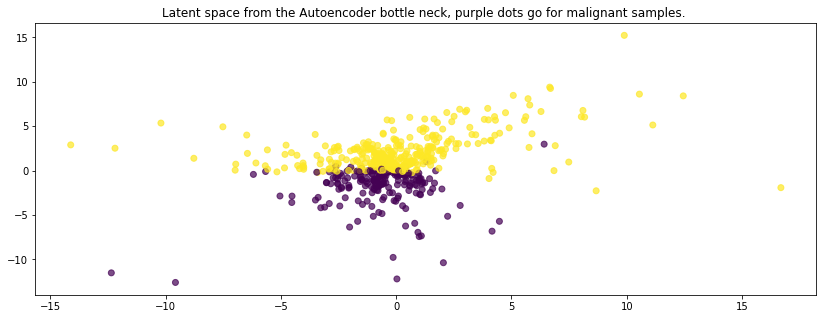

In [20]:
### BEGIN Solution
plt.figure(figsize=(14, 5))
net.eval()
enc = net.encoder(torch.FloatTensor(scaler.transform(cancer_dset['data']))).data # >>> your solution here <<<
plt.scatter(enc[:,0], enc[:,1], c=cancer_dset['target'], alpha=0.7);
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');
### END Solution

### Task 8.  Autoencoder on kMNIST. (2 points)


We will build a latent representation for `kMNIST` dataset by using our AE.

1. **(1 pt.)**  Train AE to get latent representation of the `kMNIST` dataset from `sklearn.datasets()`. Follow the instructions. Use `MSE` loss and obtain < $0.035$ on validation, with AE "bottleneck"  $\leq 40$; **(sub tasks 8.1 - 8.2)**
2.  **(1 pt.)** Plot 10 images and their reconstructions 2d. **(sub tasks 8.3)**

In [21]:
from torchvision.datasets import KMNIST

data_train = KMNIST(train=True, root='./kmnist', download=True)
data_test = KMNIST(train=False, root='./kmnist', download=True)

#### 8.1 Prepare the data and necessary functions.

In [22]:
x_train = np.array(data_train.data)
y_train = np.array(data_train.targets)

x_test = np.array(data_test.data)
y_test = np.array(data_test.targets)

In [23]:
# Reshape the data and scale
x_train = x_train.reshape(x_train.shape[0], -1) / 255 # >>> your solution here <<<
x_test = x_test.reshape(x_test.shape[0], -1) / 255 # >>> your solution here <<<

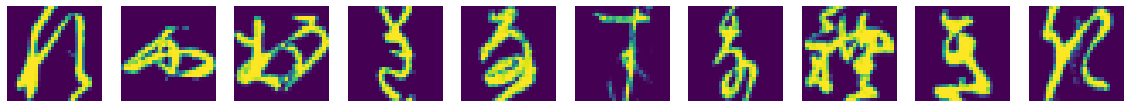

In [24]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i].reshape(28,28));
    ax[i].axis('off')

In [25]:
# BEGIN SOLUTION (do not delete this comment!)
class kMNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(kMNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32) # >>> your solution here <<<                                                        
        self.y = torch.tensor(y, dtype=torch.float32) # >>> your solution here <<<
    
    def __len__(self):
        return  len(self.X)
    
    def __getitem__(self, idx):
        return  self.X[idx], self.y[idx]
# END Solution (do not delete this comment!)

In [26]:
train_kmnist = kMNISTData(x_train, y_train) 
test_kmnist = kMNISTData(x_test, y_test) 

#### 8.2 Create encoder and decoder network for kMNIST. 
You can either use convolutions or flatten the images and use linear layers. You can choose hidden size (not larger than 40) and any architecture you like. 

In [27]:
# BEGIN SOLUTION (do not delete this comment!)

encoder = lambda hid: nn.Sequential(
                        nn.Linear(28*28, 300),
                        nn.LeakyReLU(),
                        nn.BatchNorm1d(300),
                        nn.Linear(300, 100),
                        nn.Dropout(p=0.2),
                        nn.LeakyReLU(),
                        nn.Linear(100, hid),
                        ) 

decoder = lambda hid: nn.Sequential(
                        nn.Linear(hid, 100),
                        nn.LeakyReLU(),
                        nn.Linear(100, 300),
                        nn.LeakyReLU(),
                        nn.Linear(300, 28*28),
                        nn.Sigmoid()
                        ) 

# END Solution (do not delete this comment!)

In [28]:
# BEGIN SOLUTION (do not delete this comment!)

device = "cpu" # >>> your solution here <<<
epochs = 25
net = MyFirstAE(encoder(40), decoder(40)) 
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr = 0.005) # >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.10) # >>> your solution here <<<

train_loader = torch_data.DataLoader(train_kmnist, batch_size=500, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=500, shuffle=False) 

# END Solution (do not delete this comment!)

In [29]:
train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)

Epoch 1/25 || Loss:  Train 0.0751 | Validation 0.0596
Epoch 2/25 || Loss:  Train 0.0532 | Validation 0.0501
Epoch 3/25 || Loss:  Train 0.0473 | Validation 0.0455
Epoch 4/25 || Loss:  Train 0.0442 | Validation 0.0431
Epoch 5/25 || Loss:  Train 0.0422 | Validation 0.0410
Epoch 6/25 || Loss:  Train 0.0410 | Validation 0.0394
Epoch 7/25 || Loss:  Train 0.0400 | Validation 0.0389
Epoch 8/25 || Loss:  Train 0.0392 | Validation 0.0387
Epoch 9/25 || Loss:  Train 0.0385 | Validation 0.0376
Epoch 10/25 || Loss:  Train 0.0379 | Validation 0.0367
Epoch 11/25 || Loss:  Train 0.0375 | Validation 0.0362
Epoch 12/25 || Loss:  Train 0.0369 | Validation 0.0354
Epoch 13/25 || Loss:  Train 0.0366 | Validation 0.0350
Epoch 14/25 || Loss:  Train 0.0362 | Validation 0.0342
Epoch 15/25 || Loss:  Train 0.0359 | Validation 0.0340
Epoch 16/25 || Loss:  Train 0.0357 | Validation 0.0336
Epoch 17/25 || Loss:  Train 0.0355 | Validation 0.0335
Epoch 18/25 || Loss:  Train 0.0351 | Validation 0.0330
Epoch 19/25 || Loss

#### 8.3 Plot any 10 images and their reconstructions.

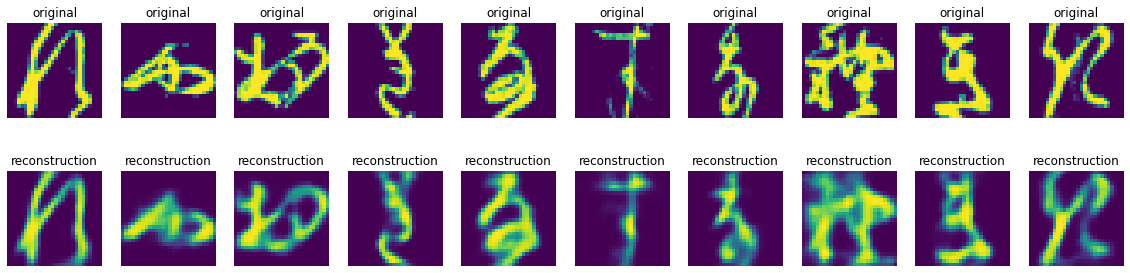

In [30]:
# BEGIN SOLUTION (do not delete this comment!)

fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    im = train_kmnist[i][0]
    rec = net(torch.FloatTensor(im.reshape(1, -1))).data.numpy() # >>> your solution here <<<
    ax[0, i].imshow(im.reshape(28,28)); ##### Apparently, it should be im (not im[0])
    ax[1, i].imshow(rec.reshape(28, 28)); # >>> your solution here <<<);
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ##### Let's add titles as in expected output:
    ax[0, i].set_title("original")
    ax[1, i].set_title("reconstruction")
        
# END Solution (do not delete this comment!)

## Task 9. Convolutional NN (4 points)


In this task, you will need to answer two questions and train a convolution neural network for a task of sound classification. 

- **(1 pt.)** Debug the given convolutional neural network and explain what's wrong with it and how to fix it. You will need to identify at least 4 problems; **(sub-tasks 9.1)**

- **(1 pt.)** Compute manually outputs of each layer, often when we build a neural network we need to know the output sizes of a layer before we add the next on; **(sub-tasks 9.2)**

- **(2 pt.)** Build your own convolutional NN and train it for the task of sound classification. Your goal is to achieve maximum quality > 70%  1pt and > 90% 2pt. **(sub-tasks 9.3 - 9.6)**

#### 9.1 Debug this convolutional neural network and write down proposed fixes. Ther are at least four fixes that can be applied. Explain your answers.

In [31]:
# # assuming input shape [batch, 3, 32, 32]
# cnn = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=512, kernel_size=(3,3)),
#     nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3,3)),
#     nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(3,3)),
#     nn.ReLU(),
#     nn.MaxPool2d((1,1)),
#     nn.Conv2d(in_channels=10, out_channels=3, kernel_size=(10,10)),
#     nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(10,10)),
#     nn.MaxPool2d((15,15)),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(10,10)),
#     nn.Softmax(),
#     Flatten(),
#     nn.Linear(64, 256),
#     nn.Softmax(),
#     nn.Linear(256, 10),
#     nn.Sigmoid(),
#     nn.Dropout(0.5)
#    )

In [32]:
# BEGIN SOLUTION (do not delete this comment!)

# Your answers:

# The enumeration according to Jupiter [1st line: "# assuming input...", 2nd: "cnn = nn.Sequential(", etc.]
# 1. line 3   ||| in_channels=1 -> in_channels=3 ||| since input has 3 channels
# 2. line 10  ||| (15,15) -> (2,2) ||| output from the previous line has shape [batch, 64, 8, 8], 
#                                      so MaxPool shoud be < or = (8,8)
# 3. line 11  ||| kernel_size=(10,10) -> kernel_size=(2,2) ||| because output from the previous line has
#                                                              (width, height) < (10,10)
# 4. line 13  ||| Flatten() -> nn.Flatten() ||| misprint
# 5. line 14  ||| nn.Linear(64, 256) -> nn.Linear(1152, 256) ||| output from the previous line has shape [batch, 1152]

# These were code bugs, i.e. without fixing them the code won't even work. 
# However, if in this task we are asked to find problems of the architecture itself, then:
# 1. Softmax is not used as activation function. It could be used at the last layer, 
#    to obtain probabilities of each class.
# 2. Activation functions are needed between the convilutional layers (Conv2d).
# 3. MaxPool with (1,1) gets maximum among 1*1=1 number, i.e. does nothing => at least (2,2)
# 4. Usually the depth of each layer (num of channels) increases along the Network 
#    whereas the width and the height decreases, so that out_channels >= in_channels.
# 5. Dropout at the last layer is very unusual step. It's better to transfer nn.Dropout(0.5) between
#    two last linear layers. Dropout models the situation when some neurons are off, but the entire
#    net continues to learn, so that each neuron becomes more responsible for providing good answer
#    (not only some subset of them).

# END Solution (do not delete this comment!)

#### 9.2 Convolutional warm up, compute manually outpust shapes for each layer.

In [33]:
# Compute output shape for each and final layers wihout running the code.
# input size x = [8, 1 , 300, 303].

# conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5), рadding = 0, stride=2) 
# conv2 = Conv2d(in_channels=16, out_chаnnels=16, kernel_size=(3, 3), рadding = 2, stride=1) 
# conv3 = Conv2d(in_channels=16, out_chаnnels=16, kernel_size=(5, 5), padding =2, stride=2) 
# maxpool1 = MаxPool2d((2, 2))
# cnn = nn.Sequential(conv1, conv2, conv3, maxpool1)

In [34]:
# BEGIN SOLUTION (do not delete this comment!)

# example:

# conv1 
# output_h = (300 - 5+0) /2 +1 = 148
# output_w = (303 - 5+0) /2 +1 = 150

# Continue for all the layers:

### BEGIN Souluion

# conv2 
# output_h = [(148 - 3 + 2*2) / 1 + 1] = [150] = 150
# output_w = [(150 - 3 + 2*2) / 1 + 1] = [152] = 152

# conv3 
# output_h = [(150 - 5 + 2*2) / 2 + 1] = [75.5] = 75
# output_w = [(152 - 5 + 2*2) / 2 + 1] = [76.5] = 76

# maxpool1 = MaxPool2d((2, 2))
# output_h = [(75 - 2) / 2 + 1] = [37.5] = 37
# output_w = [(76 - 2) / 2 + 1] = [38] = 38

# final layer output = [8, 16, 37, 38] 

# END Solution (do not delete this comment!)

#### 9.3 Convolutional networks for sound classication

- Now your task is to classify sounds using the convolutional network. You can use different network architectures. And your goal is to get the highest score possible.

- First of all, we will preprocess audio into spectrograms, that you will be able to treat them as images.

In [35]:
# imports

import os
import torch
import numpy as np
import torch.nn as nn
from torch import Tensor

!pip install torchaudio
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,Dataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [36]:
# Get the dataset

dataset = torchaudio.datasets.SPEECHCOMMANDS('./' , url = 'speech_commands_v0.02', 
                                       folder_in_archive= 'SpeechCommands', download = True)

### Let's look at the dataset.

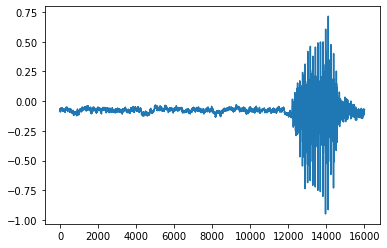

In [37]:
plt.figure()
plt.plot(dataset[0][0].t())

In [38]:
print('Label: ',dataset[11760][2])
Audio(np.array(dataset[11760][0].t()).reshape(-1), rate=16000)

Label:  down


#### Actually, we could use really long sequences to classify our samples but it's better to work with them as spectrograms so we can use convolutional layers.

Shape of spectrogram: torch.Size([1, 101, 161])


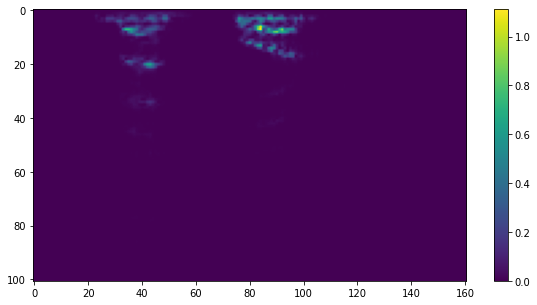

In [39]:
specgram = torchaudio.transforms.Spectrogram(n_fft=200, normalized=True)(dataset[77][0])

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure(figsize=(10,5))
plt.imshow(specgram[0,:,:].numpy());
plt.colorbar()
plt.show()

In [40]:
# Some preprocessing routine
# Filter samples only with 16000 sampling rate
# Make labels dictionary

count = 0
wave = [] 
labels = [] 
labels_dict = {} 

for i in range(0,105829):
    if dataset[i][0].shape == (1,16000):
        wave.append(dataset[i][0])
        labels.append(dataset[i][2])

In [41]:
set_labels = list(set(labels))
labels_dict = {set_labels[i] : i for i in range(len(set_labels))}
labels_dict

{'backward': 11,
 'bed': 26,
 'bird': 24,
 'cat': 23,
 'dog': 9,
 'down': 2,
 'eight': 19,
 'five': 1,
 'follow': 15,
 'forward': 34,
 'four': 13,
 'go': 25,
 'happy': 30,
 'house': 16,
 'learn': 5,
 'left': 18,
 'marvin': 32,
 'nine': 4,
 'no': 20,
 'off': 0,
 'on': 33,
 'one': 12,
 'right': 21,
 'seven': 6,
 'sheila': 8,
 'six': 10,
 'stop': 29,
 'three': 27,
 'tree': 3,
 'two': 22,
 'up': 17,
 'visual': 28,
 'wow': 14,
 'yes': 7,
 'zero': 31}

#### 9.4 Your task right now is to implement a speech dataloader it will be almost the same as in the previous tasks.

In [42]:
transformation = torchaudio.transforms.Spectrogram(n_fft=200, normalized=True)

### BEGIN Solution

class SpeechDataLoader(Dataset):
    
    def __init__(self, data, labels, label_dict, transform=None):
        self.data = data
        self.labels = labels
        self.label_dict = label_dict
        self.transform = transform
            
    def __len__(self):
        return len(self.data) # >> Your code is here << #    
    
    def __getitem__(self,idx):
        waveform = self.data[idx] # >> Your code is here << #    
        specgram = self.transform(waveform) # >> Your code is here << #

        if self.labels[idx] in self.label_dict:
            label = self.label_dict[self.labels[idx]]

        return specgram, label
    
# END Solution (do not delete this comment!)

In [43]:
torch.manual_seed(0)

dataset= SpeechDataLoader(wave, labels, labels_dict, transformation)

traindata, testdata = random_split(dataset, [round(len(dataset)*.8), round(len(dataset)*.2)], )

train_loader = DataLoader(traindata, batch_size=100, shuffle=True)

val_loader = DataLoader(testdata, batch_size=100, shuffle=True)

#### 9.5 Your task is to build a convolutional neural network that  yields a high score.

In [44]:
# BEGIN Solution  (do not delete this comment!)

class NN2D(nn.Module):
    def __init__(self, num_class):
        super(NN2D,self).__init__()
        # >> YOUR CODE GOES << #
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, (3, 3))
        self.maxPool = nn.MaxPool2d((3, 3))
        self.conv3 = nn.Conv2d(128, 256, (3, 3))
        self.maxPool2 = nn.MaxPool2d((2, 2))
        self.conv4 = nn.Conv2d(256, 512, (3, 3))
        self.maxPool3 = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(p = 0.25)
        self.fc1 = nn.Linear(4096, 2048)
        self.dropout2 = nn.Dropout(p = 0.25)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, num_class)
    
    def forward(self, x):
        # >> YOUR CODE GOES << #
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxPool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxPool2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxPool3(x)
        x = x.view(-1, 4096)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        out = self.fc3(x)
        
        return out 
    
# END Solution (do not delete this comment!)

In [45]:
# BEGIN Solution  (do not delete this comment!)

net = NN2D(len(labels_dict)) # >> Your code is here << #    

criterion = nn.CrossEntropyLoss()# >> Your code is here << #    
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0005) # >> Your code is here << # 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.10)  # >> Your code is here << # 

# END Solution (do not delete this comment!)

#### 9.6 Almost there, now, we need to rewrite our training loop a little bit.

In [46]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, device='cpu'):
    net.to(device)
    freq = max(epochs//15,1)
 
    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        for X, target in train_loader:

            X, target = X.to(device), target.to(device)
            
            ### BEGIN Solution  (do not delete this comment!)
            
            # Perform one step of minibatch stochastic gradient descent
            # >>> your solution here <<<
            optimizer.zero_grad()
            forward_step = net(X)
            loss = criterion(forward_step, target)
            loss.backward()
            optimizer.step()
            losses_train.append(loss.item())
            
            # END Solution (do not delete this comment!)
            
        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            y_pred_val =  []
            y_true_val = []

            net.eval()
            for X, target in val_loader:
                X, target = X.to(device), target.to(device)
                losses_val = []
                
                # BEGIN Solution  (do not delete this comment!)
                
                # Compute the validation loss
                # >>> your solution here <<<
                target_hat_val = net(X)
                loss_val = criterion(target_hat_val, target)
                losses_val.append(loss_val.item())
                
                # END Solution (do not delete this comment!)
                
                y_pred_val.extend(target_hat_val.argmax(1).tolist())
                y_true_val.extend(target.tolist())

            mean_val = sum(losses_val)/len(losses_val)
            mean_train = sum(losses_train)/len(losses_train)

            print('Val epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(mean_train), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_true_val, y_pred_val)) )

In [47]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(num_epochs, net, criterion, optimizer, train_loader, val_loader, scheduler, device='cuda')

Val epoch 1 , Loss : 2.57 , Accuracy on test: 0.544
Val epoch 2 , Loss : 1.22 , Accuracy on test: 0.717
Val epoch 3 , Loss : 0.857 , Accuracy on test: 0.777
Val epoch 4 , Loss : 0.686 , Accuracy on test: 0.815
Val epoch 5 , Loss : 0.567 , Accuracy on test: 0.839
Val epoch 6 , Loss : 0.491 , Accuracy on test: 0.855
Val epoch 7 , Loss : 0.429 , Accuracy on test: 0.863
Val epoch 8 , Loss : 0.384 , Accuracy on test: 0.869
Val epoch 9 , Loss : 0.263 , Accuracy on test: 0.89
Val epoch 10 , Loss : 0.239 , Accuracy on test: 0.891
Val epoch 11 , Loss : 0.229 , Accuracy on test: 0.895
Val epoch 12 , Loss : 0.219 , Accuracy on test: 0.894
Val epoch 13 , Loss : 0.208 , Accuracy on test: 0.893
Val epoch 14 , Loss : 0.204 , Accuracy on test: 0.897
Val epoch 15 , Loss : 0.197 , Accuracy on test: 0.895
Val epoch 16 , Loss : 0.188 , Accuracy on test: 0.898
Val epoch 17 , Loss : 0.176 , Accuracy on test: 0.897
Val epoch 18 , Loss : 0.174 , Accuracy on test: 0.898
Val epoch 19 , Loss : 0.173 , Accuracy o